In [1]:
import subprocess
subprocess.check_output(["pip", "install", "nltk"])

subprocess.check_output(["python", "-m", "nltk.downloader", "all"])

b''

In [2]:
subprocess.check_output(["pip", "install", "imbalanced-learn"])

b'Collecting imbalanced-learn\n  Downloading https://files.pythonhosted.org/packages/e5/4c/7557e1c2e791bd43878f8c82065bddc5798252084f26ef44527c02262af1/imbalanced_learn-0.4.3-py3-none-any.whl (166kB)\nRequirement already satisfied: scipy>=0.13.3 in /opt/conda/lib/python3.6/site-packages (from imbalanced-learn)\nCollecting scikit-learn>=0.20 (from imbalanced-learn)\n  Downloading https://files.pythonhosted.org/packages/0d/3a/b92670f5c368c20329ecc4c255993fae7934564d485c3ed7ea7b8da7f741/scikit_learn-0.20.2-cp36-cp36m-manylinux1_x86_64.whl (5.4MB)\nRequirement already satisfied: numpy>=1.8.2 in /opt/conda/lib/python3.6/site-packages (from imbalanced-learn)\nInstalling collected packages: scikit-learn, imbalanced-learn\n  Found existing installation: scikit-learn 0.19.2\n    Uninstalling scikit-learn-0.19.2:\n      Successfully uninstalled scikit-learn-0.19.2\nSuccessfully installed imbalanced-learn-0.4.3 scikit-learn-0.20.2\n'

In [51]:
%pylab inline
import msgpack
import nltk
import sklearn.cluster
import message
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import time
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import train_test_split
import itertools
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from sklearn.naive_bayes import MultinomialNB


Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['clf', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(20,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def plot_2d_space(X, y, label='Classes'):
    pca = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
    X = pca.fit_transform(X)
    cmap = plt.get_cmap("jet")
    classes = np.unique(y)
    for l, c in zip(classes, np.linspace(0, 1, len(classes))):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=cmap(c), label=l, marker='.'
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [5]:
with open("/home/jovyan/ymslanda/supportnlp/tickets/all_tickets_and_comments.msgpack", "rb") as f:
    ticketcontents = msgpack.load(f, raw=False)

with open("/home/jovyan/ymslanda/supportnlp/tickets/all_tickets_fields.msgpack", "rb") as f:
    ticketfields = msgpack.load(f, raw=False)
    
with open("stopwords.msgpack", "rb") as f:
    stop_words = msgpack.load(f)
stop_words = set(stop_words).union(stopwords.words('english')).union(stopwords.words('norwegian'))

## Cluster tickets

In [6]:
def flatten_tickets():
    for orgid, org in ticketcontents.items():
        for ticketid, ticket in org.items():
            yield ticket, ticketfields[orgid][ticketid]
tickets = list(flatten_tickets())

tickettexts = [re.sub("(\\w)://(\\w)", "\\1URL\\2",
                      re.sub("(\\w):(\\w)", "\\1COLON\\2",
                             re.sub("(\\w)/(\\w)", "\\1SLASH\\2",
                                    re.sub("(\\w)\\.(\\w)", "\\1DOT\\2",
                                         ("%(subject)s %(description)s" % ticket)))))
              for ticket, fields in tickets]
ticketservices = [fields.get("Service", None) or "unknown" for ticket, fields in tickets]
all_services = list(set(ticketservices))
all_services.sort()

In [75]:
vectorizer = TfidfVectorizer(use_idf=True, stop_words=stop_words, ngram_range=(1, 2))
X_all = vectorizer.fit_transform(tickettexts)

Y_all = np.fromiter((all_services.index(service) for service in ticketservices), dtype=int, count=len(ticketservices))

In [76]:
yorder, ycount = np.unique(Y_all, return_counts=True)
srt = ycount.argsort()
yorder = yorder[srt]
ycount = ycount[srt]

filteredclasses = yorder[ycount > 100]

X_filtered = X_all[np.isin(Y_all,filteredclasses),:]
Y_filtered = Y_all[np.isin(Y_all,filteredclasses)]
filtered_class_names = np.array(all_services)[filteredclasses]


X_filtered = X_all
Y_filtered = Y_all
filtered_class_names = np.array(all_services)



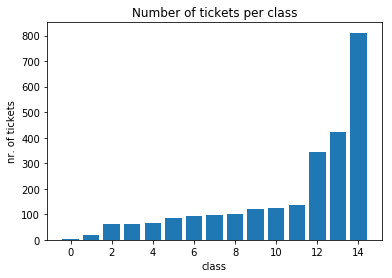

In [77]:

plt.bar(np.arange(len(ycount)), ycount)
plt.title("Number of tickets per class")
plt.xlabel("class")
plt.ylabel("nr. of tickets")
plt.show()

In [78]:
#resampler = SMOTETomek(smote=SMOTE(sampling_strategy='auto', random_state=None, k_neighbors=5, m_neighbors='deprecated', out_step='deprecated', kind='deprecated', svm_estimator='deprecated', n_jobs=1, ratio=None)
resampler = TomekLinks()
X, Y = resampler.fit_sample(X_filtered, Y_filtered)

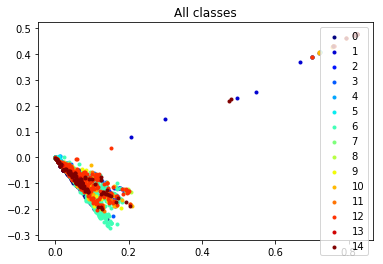

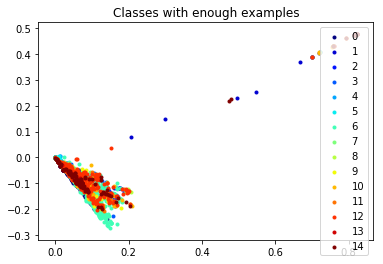

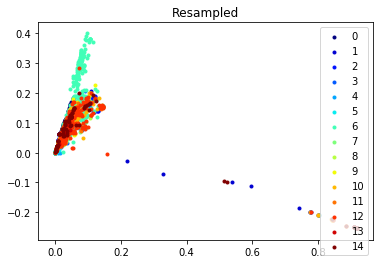

In [79]:
plot_2d_space(X_all, Y_all, "All classes")
plot_2d_space(X_filtered, Y_filtered, "Classes with enough examples")
plot_2d_space(X, Y, "Resampled")

In [80]:
pca = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
X_red = pca.fit_transform(X)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=4849)

In [82]:
#model = svm.SVC()
model = MultinomialNB()

In [83]:
model.fit(X_train, y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Confusion matrix, without normalization


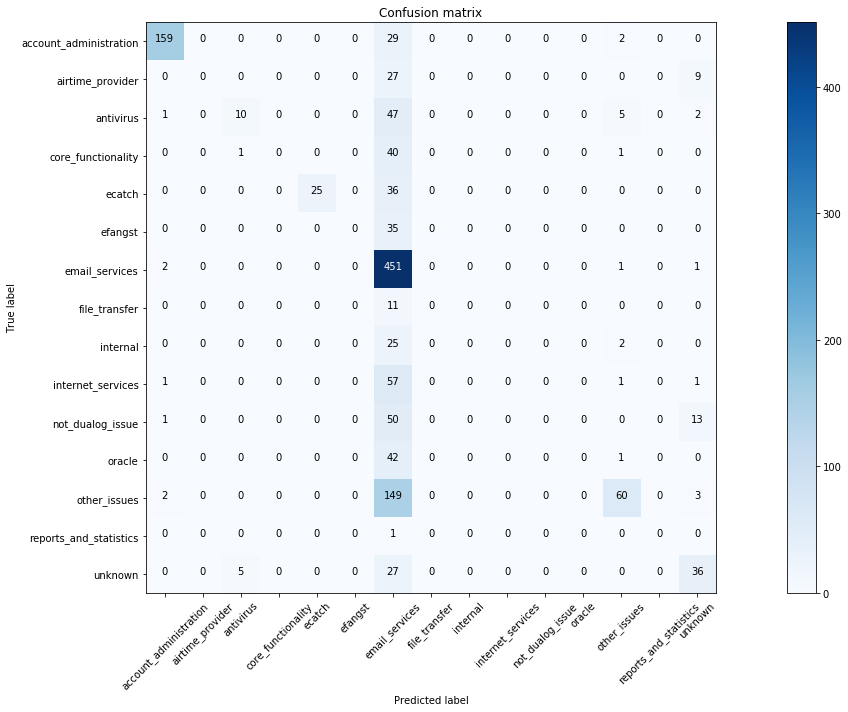

In [84]:
y_train_pred = model.predict(X_train)
plot_confusion_matrix(sklearn.metrics.confusion_matrix(y_train, y_train_pred), filtered_class_names)

Confusion matrix, without normalization


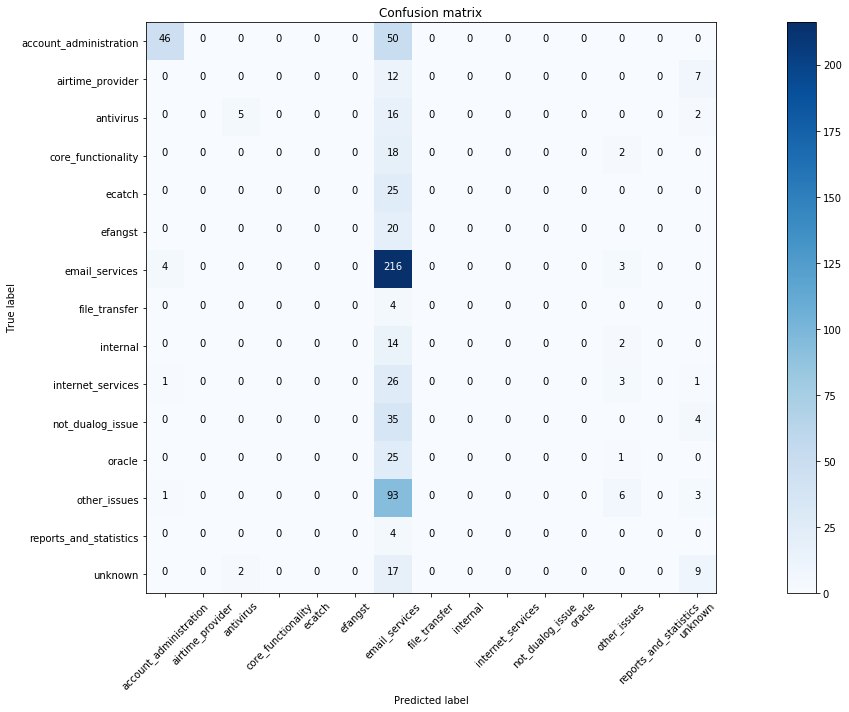

In [85]:
y_test_pred = model.predict(X_test)
plot_confusion_matrix(sklearn.metrics.confusion_matrix(y_test, y_test_pred),  filtered_class_names)